## **DEPENDENCIES**

In [ ]:
## !pip install -U tensorflow==2.7.1
## !pip install scikeras
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers
!pip install pretty-confusion-matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=8d88ce7d08395eb99b72043c9c3f21821cc4ff440ffc740376d254731a209c21
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.8 

In [ ]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, concatenate, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [ ]:
print(tf.__version__)

2.6.4


In [ ]:
# HYPER PARAMETERS
NUM_OF_ASPECTS = 7
EPOCHS = 150
MAXLEN = 768
LSTM_UNITS = 256
SAVE_PATH = "./MultiTask_Model-POS-SciBERT-epoch150.h5"

## **DATASET** : 

I. **REVIEWS** <br>
II. **LABELS:**<br>

**A. Aspect Category**
1.  Clarity (CLA)
2. Motivation/Impact (MOT)
2.   Originality (ORI)
3.   Soundness/Correctness (SOU)
2.   Substance (SUB)
1.   Replicability (REP)
2.   Meaningful Comparison (CMP)
<br>

**B. Aspect Sentiment** <br>
1.  Positive
2.  Negative



## **LOAD PROCESSED INPUT**

In [ ]:
import pickle

## LOAD POS OHE & SCIBERT EMBEDS ==> "ADD THE PATH URL HERE"
with open('../input/multitask-pos-scibert/reviews_train.pickle', 'rb') as handle:
    reviews_train = pickle.load(handle)
    handle.close()
    
with open('../input/multitask-pos-scibert/pos_embeds_train.pickle', 'rb') as handle:
    pos_embeds_train = pickle.load(handle)
    handle.close() 

with open('../input/multitask-pos-scibert/sci_embeds_train.pickle', 'rb') as handle:
    sci_embeds_train = pickle.load(handle)
    handle.close()
    
with open('../input/multitask-pos-scibert/y_ohe_train.pickle', 'rb') as handle:
    y_ohe_train = pickle.load(handle)
    handle.close()
    
with open('../input/multitask-pos-scibert/reviews_test.pickle', 'rb') as handle:
    reviews_test = pickle.load(handle)
    handle.close()
    
with open('../input/multitask-pos-scibert/pos_embeds_test.pickle', 'rb') as handle:
    pos_embeds_test = pickle.load(handle)
    handle.close() 

with open('../input/multitask-pos-scibert/sci_embeds_test.pickle', 'rb') as handle:
    sci_embeds_test = pickle.load(handle)
    handle.close()
    
with open('../input/multitask-pos-scibert/y_ohe_test.pickle', 'rb') as handle:
    y_ohe_test = pickle.load(handle)
    handle.close()



2022-10-26 19:06:07.984499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 19:06:07.985681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 19:06:07.986417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 19:06:07.988508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
aspect_categories = y_ohe_train.columns[:-1]
y_ohe_train['polarity'] = np.where(y_ohe_train['polarity'] == -1, 0, 1)
y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

In [ ]:
reviews_train.shape, pos_embeds_train.shape, sci_embeds_train.shape , y_ohe_train.shape

((161235,),
 TensorShape([161235, 1, 46]),
 TensorShape([161235, 1, 768]),
 (161235, 8))

In [ ]:
reviews_test.shape, pos_embeds_test.shape, sci_embeds_test.shape , y_ohe_test.shape

((40309,),
 TensorShape([40309, 1, 46]),
 TensorShape([40309, 1, 768]),
 (40309, 8))

In [ ]:
aspect_categories = y_ohe_train.columns[:-1]

## **A) POS FEATURE EXTRACTION**

In [ ]:
import nltk
# from nltk.tag.stanford import StanfordPOSTagger

# tagdict = load('help/tagsets/upenn_tagset.pickle')
# all_pos_tags = list(tagdict.keys())
all_pos_tags = ['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS', 'UNK']

In [ ]:
def OHE(sent_tag):
    ohe_df = []
    for word in sent_tag:
        row = [0]*len(all_pos_tags)
        row[all_pos_tags.index(word)] = 1
        ohe_df.append(row)
        
    return ohe_df


def POSPreProcess(reviews):
    for review in reviews: 
        sent_tag = [row[-1] for row in nltk.pos_tag(nltk.word_tokenize(review)) ]
        # OHE
        ohe_sent = OHE(sent_tag)
        
    return ohe_sent
    
# SAMPLE
# POSPreProcess([df.loc[109].review])
# POSPreProcess(df.loc[:2].review.values)

## **B) SCI-BERT**

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModel
scibert_name = 'gsarti/scibert-nli'
tokenizer = AutoTokenizer.from_pretrained(scibert_name) 
scibert_model = AutoModel.from_pretrained(scibert_name)

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

In [ ]:
def sent2SciEmbed(scibert_model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = scibert_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2SciEmbed(scibert_model, sent)
outputs[1].shape


torch.Size([1, 768])

### **MULTI-TASK with Attention**

In [ ]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.dot(x,self.W) + self.b
        a = K.softmax(e, axis=1)
        output = x*a
        # if self.return_sequences:
        #     return output
        
        return K.sum(output, axis=1)

In [ ]:
# POS MODEL
pos_ip = Input(shape= (None, len(all_pos_tags)), name='POS INPUT')
con = Conv1D(filters=1, kernel_size=1, activation='relu')(pos_ip)
pos_features = MaxPooling1D(pool_size=1)(con)
POS_MODEL = Model(inputs=pos_ip, outputs=pos_features)

# SCIBERT MODEL
sci_embed = Input(shape= (None, MAXLEN), name='SCIBERT INPUT')

# MERGE FESATURES
combined_features = concatenate([POS_MODEL.output, sci_embed])

# SHARED LAYER MODEL
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(combined_features)
repeat_op = RepeatVector(NUM_OF_ASPECTS)(biLSTM)

attentions=[]
for i in range(NUM_OF_ASPECTS):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)

concate_attention  = Concatenate()(attentions)
flatten = Flatten()(concate_attention)

# BRANCH 1
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2
dense2 =  Dense(60, activation='relu', name='POLARITY_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='POLARITY_OUTPUT')(dense2)


In [ ]:
MULTITASK_MODEL = Model(inputs=[POS_MODEL.input , sci_embed], outputs=[category_output, polarity_output])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


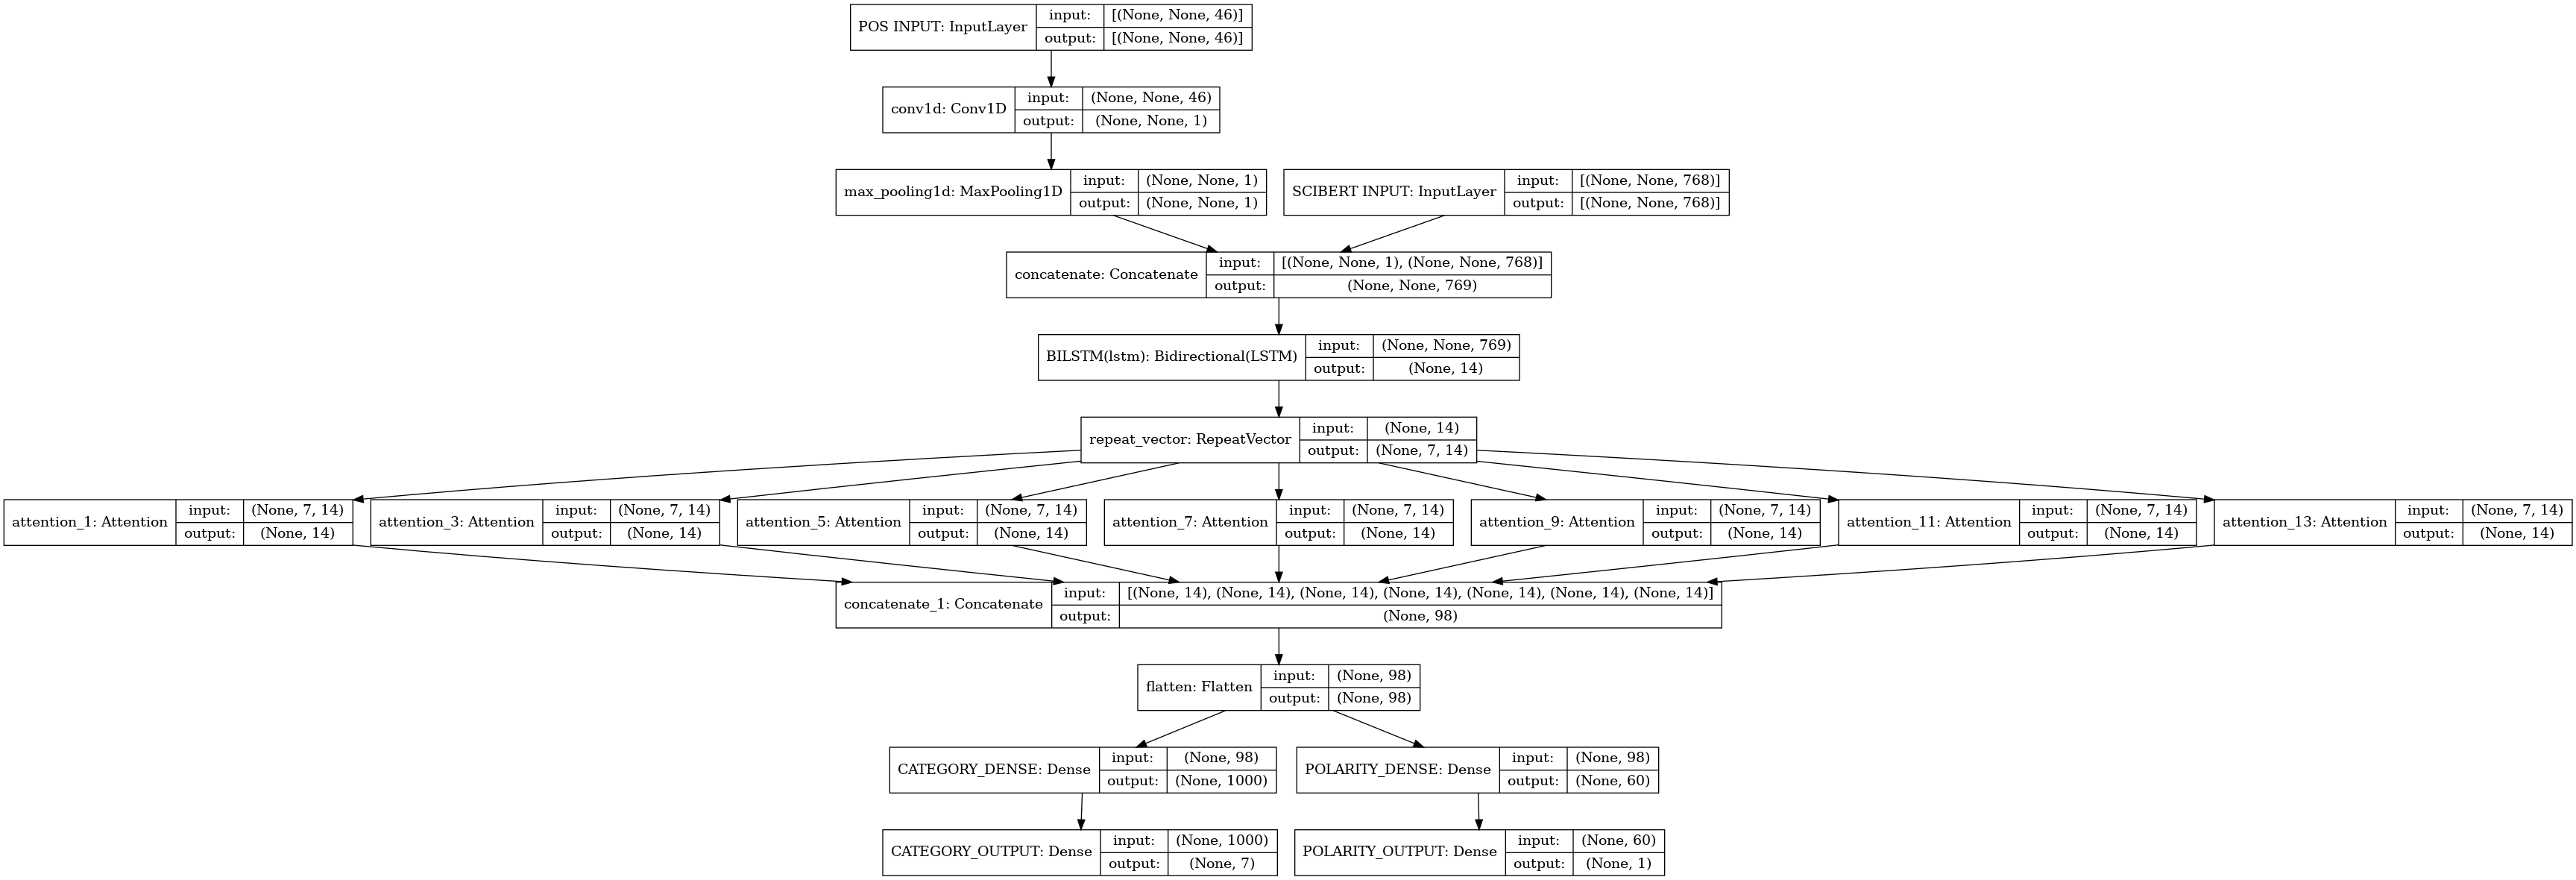

In [ ]:
tf.keras.utils.plot_model(MULTITASK_MODEL, to_file='multi-task_model.png', show_shapes=True)

In [ ]:
metrics =[ 
    'accuracy', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall()
]

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

loss = { 'CATEGORY_OUTPUT': 'categorical_crossentropy', 
        'POLARITY_OUTPUT': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT': 1.0, 
               'POLARITY_OUTPUT': 1.0
              }


MULTITASK_MODEL.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam', 
                        metrics=['accuracy']) 


MULTITASK_MODEL.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
POS INPUT (InputLayer)          [(None, None, 46)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 1)      47          POS INPUT[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 1)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
SCIBERT INPUT (InputLayer)      [(None, None, 768)]  0                                            
____________________________________________________________________________________________

In [ ]:
history = MULTITASK_MODEL.fit(
                          [pos_embeds_train , sci_embeds_train], 
                          y =  {
                          'CATEGORY_OUTPUT': y_ohe_train[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_train.polarity.values
                          }, 
                            validation_data = ([pos_embeds_test , sci_embeds_test], {
                          'CATEGORY_OUTPUT': y_ohe_test[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2
                          )

2022-10-26 19:06:23.545845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-10-26 19:06:28.165595: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5039/5039 - 60s - loss: 1.1295 - CATEGORY_OUTPUT_loss: 0.9485 - POLARITY_OUTPUT_loss: 0.1810 - CATEGORY_OUTPUT_accuracy: 0.6558 - POLARITY_OUTPUT_accuracy: 0.9249 - val_loss: 0.9808 - val_CATEGORY_OUTPUT_loss: 0.8214 - val_POLARITY_OUTPUT_loss: 0.1594 - val_CATEGORY_OUTPUT_accuracy: 0.7053 - val_POLARITY_OUTPUT_accuracy: 0.9332
Epoch 2/150
5039/5039 - 47s - loss: 0.9636 - CATEGORY_OUTPUT_loss: 0.8105 - POLARITY_OUTPUT_loss: 0.1530 - CATEGORY_OUTPUT_accuracy: 0.7088 - POLARITY_OUTPUT_accuracy: 0.9358 - val_loss: 0.9577 - val_CATEGORY_OUTPUT_loss: 0.7833 - val_POLARITY_OUTPUT_loss: 0.1743 - val_CATEGORY_OUTPUT_accuracy: 0.7182 - val_POLARITY_OUTPUT_accuracy: 0.9260
Epoch 3/150
5039/5039 - 49s - loss: 0.9152 - CATEGORY_OUTPUT_loss: 0.7706 - POLARITY_OUTPUT_loss: 0.1446 - CATEGORY_OUTPUT_accuracy: 0.7230 - POLARITY_OUTPUT_accuracy: 0.9390 - val_loss: 0.8760 - val_CATEGORY_OUTPUT_loss: 0.7348 - val_POLARITY_OUTPUT_loss: 0.1412 - val_CATEGORY_OUTPUT_accuracy: 0.7377 - val_POLARITY_OUTPUT_acc

## ANALYSIS

In [ ]:
history.history.keys()

dict_keys(['loss', 'CATEGORY_OUTPUT_loss', 'POLARITY_OUTPUT_loss', 'CATEGORY_OUTPUT_accuracy', 'POLARITY_OUTPUT_accuracy', 'val_loss', 'val_CATEGORY_OUTPUT_loss', 'val_POLARITY_OUTPUT_loss', 'val_CATEGORY_OUTPUT_accuracy', 'val_POLARITY_OUTPUT_accuracy'])

In [ ]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
category_loss = history.history[metrics_keys[1]]
polarity_loss = history.history[metrics_keys[2]]
category_acc = history.history[metrics_keys[3]]
polarity_acc = history.history[metrics_keys[4]]
val_loss = history.history[metrics_keys[5]]
val_category_loss = history.history[metrics_keys[6]]
val_polarity_loss = history.history[metrics_keys[7]]
val_category_acc = history.history[metrics_keys[8]]
val_polarity_acc = history.history[metrics_keys[9]]


print("\nCATEGORY ACCURACY : " , category_acc)
print("\nPOLARITY ACCURACY : " , polarity_acc)
print("\nVAL CATEGORY ACCURACY : " ,val_category_acc)
print("\nVAL POLARITY ACCURACY : " ,val_polarity_acc)
print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)


CATEGORY ACCURACY :  [0.6557819247245789, 0.7087852954864502, 0.7230377793312073, 0.7342636585235596, 0.7409371137619019, 0.7453158497810364, 0.749130129814148, 0.7551958560943604, 0.7577883005142212, 0.7619995474815369, 0.7650076150894165, 0.7668372392654419, 0.7697956562042236, 0.7721400260925293, 0.7742177844047546, 0.7776351571083069, 0.778385579586029, 0.7817533612251282, 0.7835767865180969, 0.7837628126144409, 0.7855552434921265, 0.7873290777206421, 0.7894067764282227, 0.7919992804527283, 0.7913852334022522, 0.7938598990440369, 0.7949514389038086, 0.7957949638366699, 0.7964648008346558, 0.7986417412757874, 0.7985858917236328, 0.8003349304199219, 0.8008682727813721, 0.8016435503959656, 0.8034483790397644, 0.8042236566543579, 0.8048562407493591, 0.8072564601898193, 0.8080007433891296, 0.8086767792701721, 0.8078333139419556, 0.8097931742668152, 0.8111638426780701, 0.8114429116249084, 0.8104381561279297, 0.8129872679710388, 0.8147300481796265, 0.8144757747650146, 0.8167581558227539,

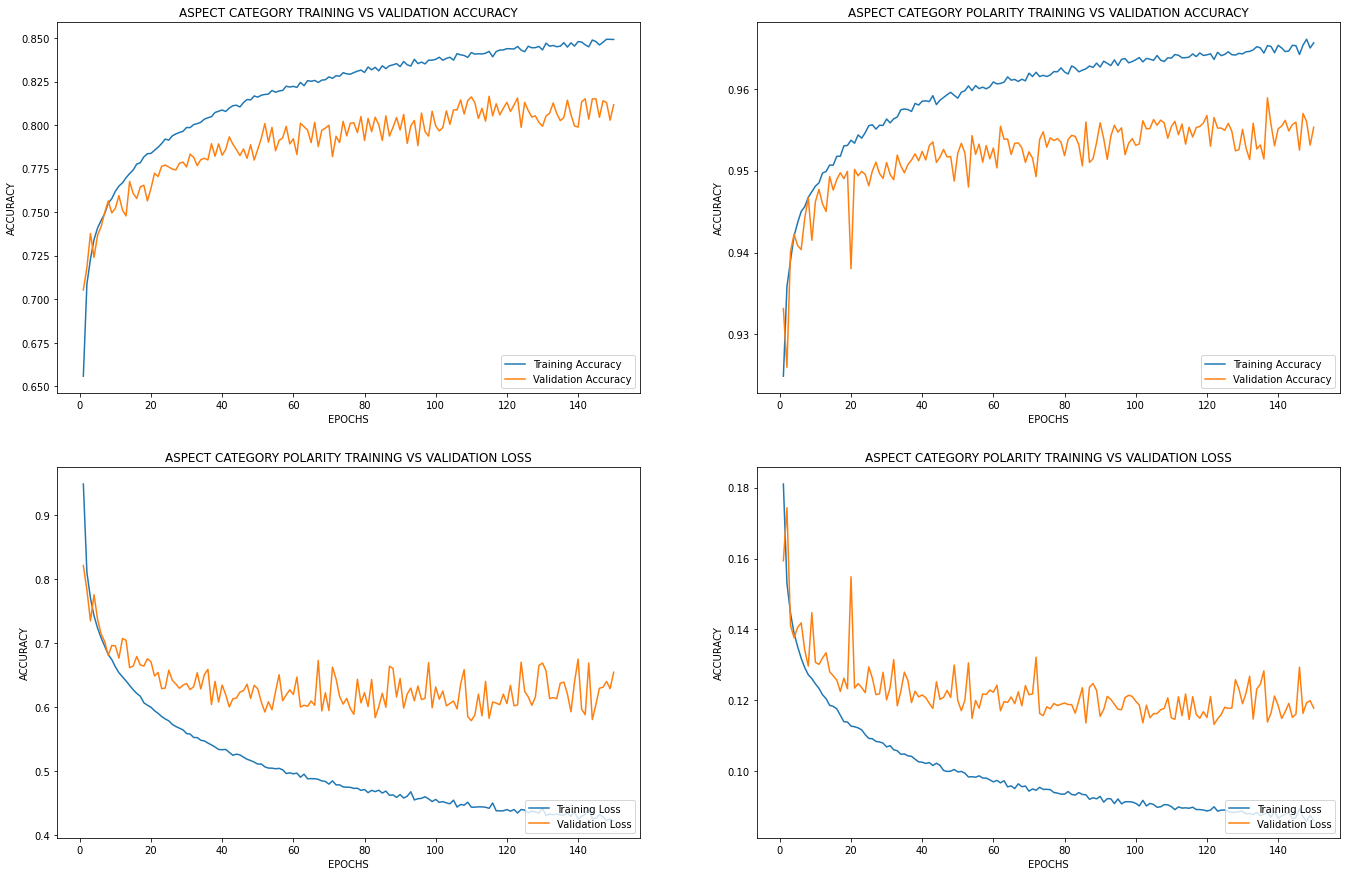

In [ ]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, category_acc, label='Training Accuracy')
plt.plot(epochs_range, val_category_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, polarity_acc, label='Training Accuracy')
plt.plot(epochs_range, val_polarity_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ASPECT CATEGORY POLARITY TRAINING VS VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')

plt.subplot(2, 2, 3)
plt.plot(epochs_range,category_loss, label='Training Loss')
plt.plot(epochs_range, val_category_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')

plt.subplot(2, 2, 4)
plt.plot(epochs_range,polarity_loss, label='Training Loss')
plt.plot(epochs_range, val_polarity_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.show()






---





## **VALIDATION**

In [ ]:
categories = y_ohe_train.columns[:-1]
polarity_labels = ['POSITIVE', 'NEGATIVE']

In [ ]:
y_pred_aspect = MULTITASK_MODEL.predict([pos_embeds_test , sci_embeds_test])
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_ohe_test[aspect_categories].values, axis=1)

In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_ohe_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect_categories, aspect_acc):
    print('',cat,"\t",round(acc, 3))
    
# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 MOT 	 0.801
 ORI 	 0.872
 SOU 	 0.669
 SUB 	 0.712
 REP 	 0.935
 CMP 	 0.871
 CLA 	 0.822


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.968
NEGATIVE 	 0.936


In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_ohe_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

              precision    recall  f1-score   support

         MOT       0.79      0.80      0.79      5758
         ORI       0.77      0.87      0.82      5759
         SOU       0.69      0.67      0.68      5758
         SUB       0.80      0.71      0.75      5759
         REP       0.89      0.94      0.91      5758
         CMP       0.85      0.87      0.86      5758
         CLA       0.90      0.82      0.86      5759

    accuracy                           0.81     40309
   macro avg       0.81      0.81      0.81     40309
weighted avg       0.81      0.81      0.81     40309



               precision    recall  f1-score   support

    POSITIVE       0.96      0.97      0.96     24603
    NEGATIVE       0.95      0.94      0.94     15706

    accuracy                           0.96     40309
   macro avg       0.95      0.95      0.95     40309
weighted avg       0.96      0.96      0.96     40309



## **CONFUSION MATRIX**

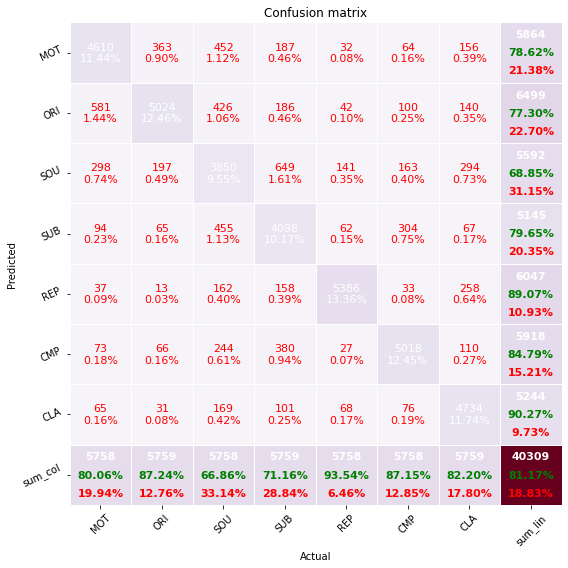

In [ ]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_aspect, index=categories, columns=categories)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

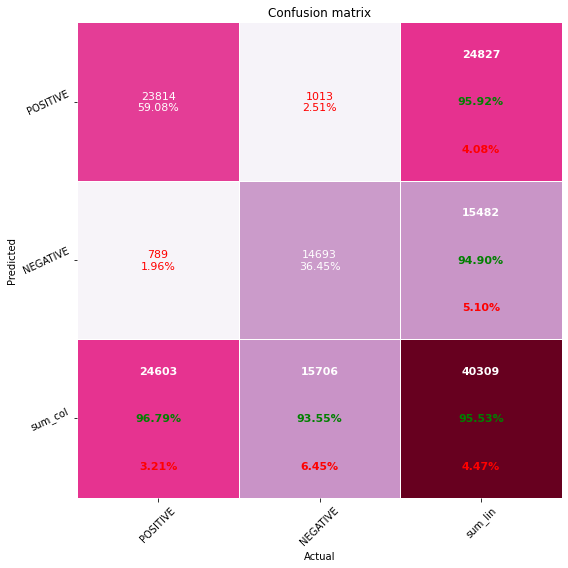

In [ ]:
df_cm = pd.DataFrame(cm_polarity, index=polarity_labels, columns=polarity_labels)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

## **INFERENCE MODEL**

In [ ]:
def predictPreprocess(sent):
    # SCIBERT EMBEDS
    outputs = sent2SciEmbed(scibert_model, sent)
    pred_X = np.array([outputs[1].detach().numpy()[0]])
    Sci_embed = tf.stack([pred_X])

    # POS EMBEDS
    POS_embed = POSPreProcess(sent.strip())
    POS_embed = tf.stack([POS_embed])
    
    return POS_embed , Sci_embed

In [ ]:
def inferenceModel(model, sent):
    labels = ['CLA', 'CMP', 'MOT', 'ORI', 'REP', 'SOU', 'SUB', 'SUM']
    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        POS_embed , Sci_embed = predictPreprocess(s.strip())
        category_probab = model.predict([POS_embed , Sci_embed])
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        results.append([labels[category_label_idx] , category_polarity, category_label])
        
    return results


In [ ]:
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy 
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . 
The approach is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(MULTITASK_MODEL, sent)

print('PREDICTED OUTPUT :', op)

PREDICTED OUTPUT : [['MOT', 1, 'POS'], ['CLA', 1, 'POS'], ['ORI', 1, 'POS']]


In [ ]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , 
it is conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces 
an interesting idea to address an important topic .'''
op = inferenceModel(MULTITASK_MODEL, sent)

# print('\nTRUE OUTPUT      : MOT')
print('PREDICTED OUTPUT :', op)

PREDICTED OUTPUT : [['CMP', 1, 'POS'], ['CLA', 1, 'POS']]
